## Standard stuff

In [1]:
import math

%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

import corner
import seaborn as sns
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


## Astropy cosmology

Documentation at: http://docs.astropy.org/en/v0.2.1/cosmology/index.html

**Note**: my astropy version is old enough to not include `Planck15`. A find and replace of `Planck13` is order if you have a newer version. The cosmology is only marginally different, but best to always be up to date.

In [2]:
import astropy
print astropy.__version__
from astropy import cosmology


1.3.dev15936


## LAL software

More information and documentation here: http://software.ligo.org/docs/lalsuite/lalsuite/index.html

In [3]:
import sys
# You don't need the following line - I needed to add it b/c my path structure is jacked up
sys.path.append('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/')
import lal, lalsimulation
from lalinference.rapid_pe import lalsimutils
from pylal.antenna import response


In [4]:
%%bash
lalapps_version

%% LAL: 6.16.1 (CLEAN e5afea6f54152c5f7e3415b426b335d9ed29efba)
%% LALFrame: 1.4.1 (CLEAN 91a5d26283954446c922ddf3f21a569baa2fb6f4)
%% LALMetaIO: 1.2.8 (CLEAN dc43b4813f7ba2c228ce5f2e6b4f99dfddb873e4)
%% LALXML: 1.2.2 (CLEAN 3ae6f485e02165c2e58e8ec099564be4d108d74b)
%% LALSimulation: 1.6.0 (CLEAN f38b2d06b8b64e8a616232c9d79439fdeca0d412)
%% LALBurst: 1.4.2 (CLEAN e46e9b24827265ded75f7005ddf5f8190d1c7096)
%% LALInspiral: 1.7.5 (CLEAN a06c9522788d4e1fce58f38fcfe6804eff0e12a7)
%% LALPulsar: 1.14.0 (CLEAN ea634b5f8e90f15947e1859093e62485e288bb15)
%% LALInference: 1.7.0 (CLEAN 3dd62b16f4460de19415ea02a3f8607467f4c89e)
%% LALStochastic: 1.1.18 (CLEAN f13aaac29235dd900d4fa03efc8b0e394c212e84)
%% LALApps: 6.19.0 (CLEAN 5e0d77a3a68496f08b41b6e21a608a25dca063da)


## Software to calculate precessional dynamics

See here: https://davidegerosa.com/precession/

The package uses [Geometrized units](https://en.wikipedia.org/wiki/Geometrized_unit_system), and so we convert from LAL conventions (SI) before inputting to the precessional calculation.

In [5]:
import precession
print precession.__version__
precession.CPUs=0 # global var autodetects the number of core in the current machine

1.0.0


# Spin Distribution Generators

There's **definitely** a better way to do this. Currently, it is just rejecting samples that do not fit the spin 

In [20]:
# Set number of samples to draw spins/masses
num_samps = 1000

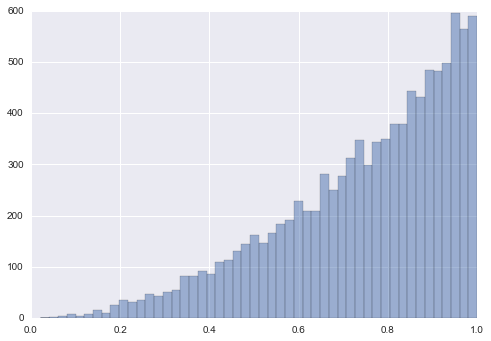

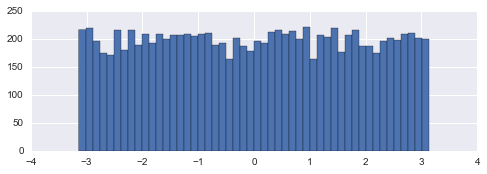

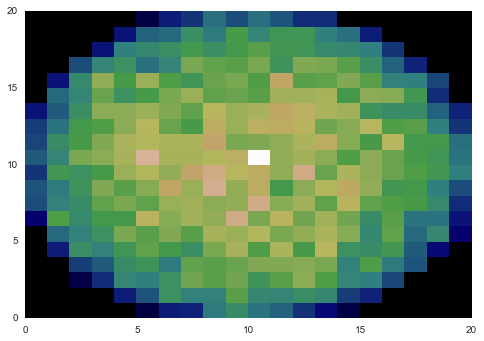

In [7]:
# Function for drawing spin isotropically
def reject_samp_iso(n, s_max=1., ndim=3):
    retval = np.empty((n, ndim))
    
    for i in range(n):
        vec = np.random.uniform(-1, 1, ndim)
        while np.dot(vec, vec) > s_max**2:
            vec = np.random.uniform(-1, 1, ndim)
        retval[i] = vec
    return retval

# Function for drawing spins with a fixed spin magnitude (+- some threshold value)
def reject_samp_uni(n, s, variance, ndim=3):
    retval = np.empty((n, ndim))
    for i in range(n):
        vec = np.random.uniform(-1, 1, ndim)
        while np.dot(vec, vec) > (s+variance)**2 or \
              np.dot(vec, vec) < (s-variance)**2:
            vec = np.random.uniform(-1, 1, ndim)
        retval[i] = vec
    return retval


# Plot spin distributions, choosing either isotropic (spins_iso) or single-valued (spins_uni)
# Uncomment out whichever one you want to plot:

spins = reject_samp_iso(num_samps)
# spins = reject_samp_uni(num_samps,.7,.02) # spin mag = [0.68,0.72]

spin_mag = numpy.sqrt(np.sum(spins**2, axis=1))
plt.figure()
plt.hist(spin_mag, bins=50, alpha=0.5)

plt.figure()
spin_theta = np.arccos(spins[:,-1] / spin_mag)
spin_phi = np.arctan2(spins[:,1], spins[:,0])
plt.hist(spin_theta, bins=50)
plt.subplot(2, 1, 2)
plt.hist(spin_phi, bins=50)

plt.figure()
h, _, _ = np.histogram2d(spins.T[0], spins.T[1], bins=(20, 20))
plt.pcolor(h, cmap=matplotlib.cm.gist_earth);

Define functions to sample binary spins, masses w/o cluster models

In [37]:
def random_m1m2(nsamp):
    return np.concatenate((np.random.uniform(30, 50, 2), np.random.uniform(0, 0.5, 1)))

def random_s1s2_iso(nsamp):
    return reject_samp_iso(nsamp), reject_samp_iso(nsamp)

def random_s1s2_uni(nsamp):
    return reject_samp_uni(nsamp,s,vari), reject_samp_uni(nsamp,s,vari)

# RATES #

### Power Spectral Density ###

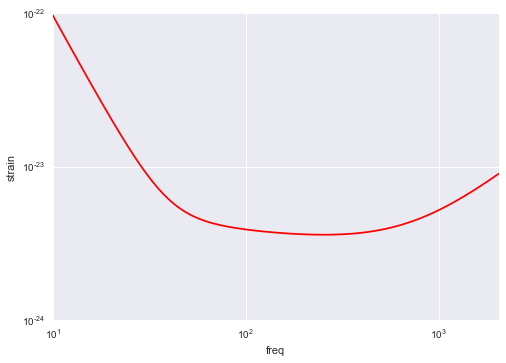

In [12]:
df = 1./32.
psd = map(lalsimulation.SimNoisePSDaLIGOZeroDetHighPower, np.arange(0, 2048 + df, df))
f = np.arange(0, 2048 + df, df)
plt.plot(f, np.sqrt(psd), 'r-')
plt.loglog()
plt.xlim(10, 2048)
plt.ylim(1e-24, 1e-22)
plt.xlabel('freq')
plt.ylabel('strain')

### Get Waveform ###

In [51]:
det = lal.LHO_4K_DETECTOR

def chi_z(m1, m2, s1z, s2z):
    '''
    Spin magnitude along L
    '''
    return ((m1*s1z + m2*s2z)/(m1+m2))

def get_waveform(z, vary_params=False, **kwargs):
    if "mchirp" in kwargs and "eta" in kwargs:
        m1, m2 = lalsimutils.m1m2(kwargs["mchirp"], kwargs["eta"])
    else:
        m1, m2 = kwargs["mass1"], kwargs["mass2"]
    m1, m2 = m1 * lal.MSUN_SI, m2 * lal.MSUN_SI
    
    if "tilt1" in kwargs and "s1" in kwargs:
        s1z = kwargs["s1"] * math.cos(kwargs["tilt1"])
        s1x, s1y = kwargs["s1"] * math.sin(kwargs["tilt1"]), 0
    elif "s1x" in kwargs and "s1y" in kwargs and "s1z" in kwargs:
        s1x, s1y, s1z = kwargs["s1x"], kwargs["s1y"], kwargs["s1z"]
    else:
        s1x, s1y, s1z = 0.0, 0.0, 0.0

    if "tilt2" in kwargs and "s2" in kwargs:
        s2z = kwargs["s2"] * math.cos(kwargs["tilt2"])
        s2x, s2y = kwargs["s2"] * math.sin(kwargs["tilt2"]), 0
    elif "s2x" in kwargs and "s2y" in kwargs and "s2z" in kwargs:
        s2x, s2y, s2z = kwargs["s2x"], kwargs["s2y"], kwargs["s2z"]
    else:
        s2x, s2y, s2z = 0.0, 0.0, 0.0
        
    flow = kwargs["flow"] if "flow" in kwargs else 10. # Stock f_low: 10 Hz
    
    # If chi_z > 0.9 then use seobnrv3
    chi_test = chi_z(m1, m2, s1z, s2z)
    if np.abs(chi_test) > 0.9:
        approx = lalsimulation.GetApproximantFromString(kwargs["approx"] if "approx" in kwargs else "SEOBNRv3")
        print 'SEOBNRv3 used for track w/ chi_z = %f' % (chi_test)
    else:
        approx = lalsimulation.GetApproximantFromString(kwargs["approx"] if "approx" in kwargs else "IMRPhenomPv2")
    
    distance = cosmology.Planck15.comoving_distance(z).value * lal.PC_SI * 1e6
    
    if vary_params:
        ra, dec = np.random.uniform(0, 2*np.pi), np.arcsin(np.random.uniform(-1, 1))
        incl, psi = np.arccos(np.random.uniform(-1, 1)), np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)

        # With pylal
        fp, fx, _, _ = response(1e9, ra, dec, incl, psi, 'radians', 'L1')
        gp, gx = (1 + np.cos(incl)**2)/2, np.cos(incl)
        # Without pylal
        # det = lal.CachedDetectors[lal.LHO_4K_DETECTOR]
        # fp, fx = lal.ComputeDetAMResponse(det.response, ra, dec, psi, 0)
        # gp, gx = (1 + numpy.cos(incl)**2)/2, numpy.cos(incl)
    else:
        phi, incl = 0., 0.
        fp, fx, gp, gx = 1, 1, 1, 1

    hpf, hxf = lalsimulation.SimInspiralFD(phi, df,
                                     # masses
                                     m1, m2,
                                     # spins
                                     s1x, s1y, s1z,
                                     s2x, s2y, s2z,
                                     # low freq, high freq, reference freq
                                     flow, 2048, flow,
                                     # comoving distance, redshift
                                     distance, z,
                                     # inclination
                                     incl, 
                                     # Tidal deformability -- ignore
                                     0.0, 0.0,
                                     # non-GR paramers, adtl parameters, amp order, phase order, approximant
                                     None, None, -1, 7, approx)

    hpf.data.data *= fp * gp
    hxf.data.data *= fx * gx
    

    return hpf, hxf

Plot sample waveform

(10, 1024)

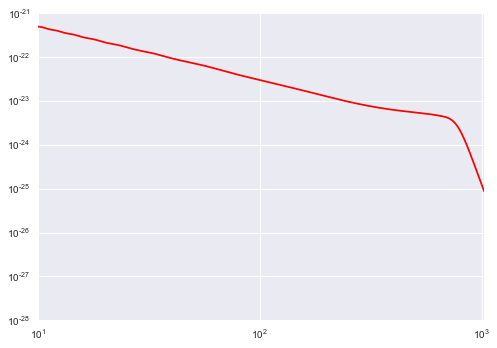

In [52]:
hpf, hxf = get_waveform(0.01, True, mass1=10., mass2=15., \
                              s1x=0.1, s1y=0.1, s1z=0.5, \
                              s2x=0.5, s2y=0.2, s2z=0.1)
hfull = np.abs(hpf.data.data - 1j*hxf.data.data)
f = np.arange(0, 2048 + df, df)
plt.plot(f, hfull, 'r-')
plt.loglog()
plt.xlim(10, 1024)
#pyplot.savefig("waveform.png")

### Import masses from Carl's cluster simulations

In [16]:
# This takes a little bit so we have it here to not interfere with initialization
from carl import masses

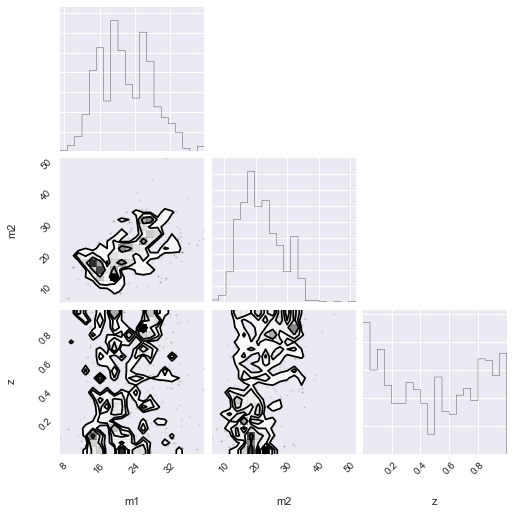

In [64]:
# Plot mass distributions with number of samples specified above
corner.corner(masses.sample_masses(num_samps).T, labels = ['m1', 'm2', 'z']);

$SNR: \rho^2 = 4 \int_{f_0}^{f_h} \frac{\tilde{h}(\bar{f})\tilde{h}(f)}{S(f)} df$

In [53]:
zmax = 2.0 # Set maximum redshift

flow = 10. # Set minimum frequency
overlap = lalsimutils.Overlap(flow, 1024., deltaF=df, psd=psd, analyticPSD_Q=False)

def snr(hp, hx, psd, flow, **kwargs):
    """
    Calculates:
    \rho^2 = 4 \int_{f_0}^{f_h} \frac{\tilde{h}^{\conj}(f)\tilde{h}(f)}{S(f)} df
    """
    ht = hp.data.data + hx.data.data
    f0_idx, flast_idx = int(numpy.round(hp.f0 / hp.deltaF)), len(ht)
    ffirst_idx = int(numpy.round(flow / hp.deltaF))
    flast_idx += f0_idx
    return 2 * np.sqrt(np.real(ht[ffirst_idx:flast_idx]*ht[ffirst_idx:flast_idx].conj()/psd[ffirst_idx:flast_idx]).sum() * hp.deltaF)

def chi_in_pl(m1, m2, s1, s2):
    """
    In plane spin magnitude.
    """
    s1p = np.sqrt(np.sum(s1[:,:2]**2, axis=1))
    s2p = np.sqrt(np.sum(s2[:,:2]**2, axis=1))
    return (m1 * s1p + m2 * s2p) / (m1 + m2)

def sample_in_z(n, mass_sampler, spin_sampler, psd, vary_params=False, calculate_overlap=False):
    snr_olap = np.zeros((n, 2))
    distance = np.zeros(n)
    m1, m2, z = mass_sampler(n)
    mc, eta = lalsimutils.Mceta(m1, m2) # gives chirp mass, eta
    s1, s2 = spin_sampler(n)
    distance = cosmology.Planck15.luminosity_distance(z).value
        
    for i in range(n):
        if i%100 == 0:
            print 'Done with %i samplings' % (i)  # Just so we can make sure that it is running
        (s1x, s1y, s1z), (s2x, s2y, s2z) = s1[i], s2[i]
        hp, hx = get_waveform(z[i], True, mass1=m1[i], mass2=m2[i], \
                              s1x=s1x, s1y=s1y, s1z=s1z, \
                              s2x=s2x, s2y=s2y, s2z=s2z)
        
        h_snr = snr(hp, hx, psd, flow)
        snr_olap[i,0] = h_snr
        
        if not calculate_overlap:
            continue
            
        hp.data.data += hx.data.data
        
        hp_a, hx_a = get_waveform(z[i], True, mass1=m1[i], mass2=m2[i], \
                              s1x=0.0, s1y=0.0, s1z=s1z, \
                              s2x=0.0, s2y=0.0, s2z=s2z)
        hp_a.data.data += hx_a.data.data
        
        snr_olap[i,1] = overlap.ip(hp, hp_a)/overlap.norm(hp)/overlap.norm(hp_a)
    
    # Save everything into a pandas dataframe
    df = pd.DataFrame({'m1':m1, 'm2':m2, 'mc':mc, 'z':z, 'd':distance, 'chi_z':chi_z(m1, m2, s1[:,2], s2[:,2]), \
                       'chi_p':chi_in_pl(m1, m2, s1, s2), 's1x':s1[:,0], 's1y':s1[:,1], 's1z':s1[:,2], 's2x':s1[:,0], \
                       's2y':s2[:,1], 's2z':s2[:,2], 'snr':snr_olap[:,0], 'overlap':snr_olap[:,1]})
                           
    return df

Do the sampling

In [65]:
# Change the spin distribution between random_s1s2_iso and random_s1s2_uni
# If random_s1s2_uni, adjust s, vari accordingly
s = 0.7; vari = 0.02
zsamp = sample_in_z(num_samps, masses.sample_masses, random_s1s2_iso, psd, calculate_overlap=True);

Done with 0 samplings
Done with 100 samplings
Done with 200 samplings
Done with 300 samplings
Done with 400 samplings
Done with 500 samplings
Done with 600 samplings
Done with 700 samplings
Done with 800 samplings
Done with 900 samplings


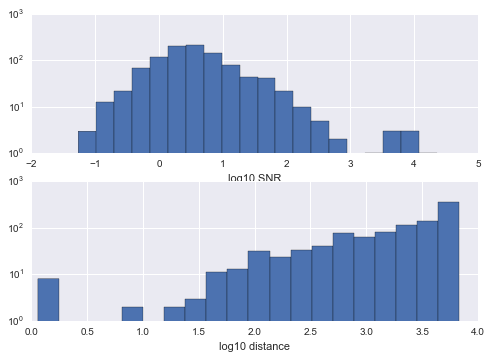

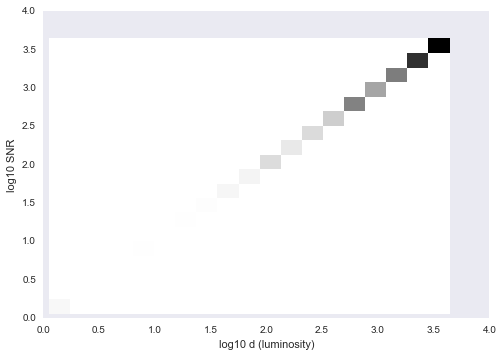

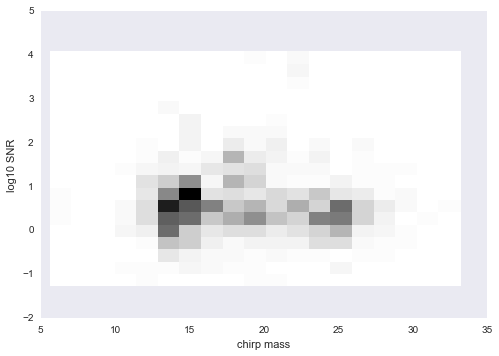

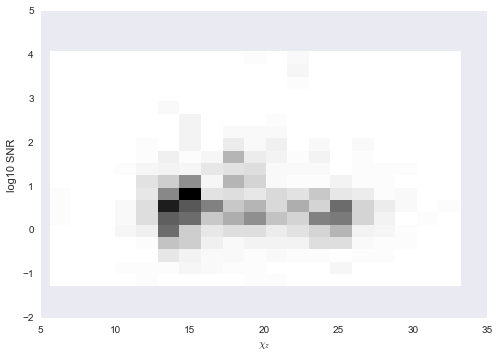

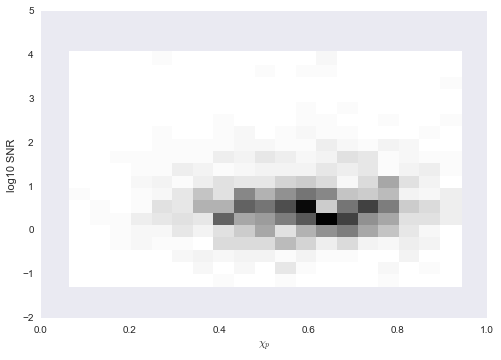

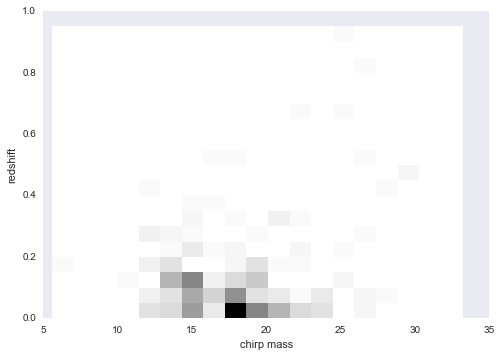

In [68]:
plt.figure()
plt.subplot(2, 1, 1)
plt.hist(np.log10(zsamp['snr']), bins=20, log=True)
plt.xlabel("log10 SNR")
plt.subplot(2, 1, 2)
plt.hist(np.log10(zsamp['d']), bins=20, log=True)
plt.xlabel("log10 distance")

# SNR vs luminosity distance
plt.figure()
h, bx, by = np.histogram2d(np.log10(zsamp['d']), np.log10(zsamp['d']), bins=20)
plt.pcolor(bx[:-1], by[:-1], h.T)
plt.xlabel("log10 d (luminosity)")
plt.ylabel("log10 SNR")

# mchirp vs SNR
plt.figure()
h, bx, by = np.histogram2d(zsamp['mc'], np.log10(zsamp['snr']), bins=20)
plt.pcolor(bx[:-1], by[:-1], h.T)
plt.xlabel("chirp mass")
plt.ylabel("log10 SNR")

# chi_z vs SNR
pyplot.figure()
h, bx, by = np.histogram2d(zsamp['mc'], np.log10(zsamp['snr']), bins=20)
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.xlabel("$\chi_z$")
pyplot.ylabel("log10 SNR")

# chi_p vs SNR
plt.figure()
h, bx, by = np.histogram2d(zsamp['chi_p'], np.log10(zsamp['snr']), bins=20)
plt.pcolor(bx[:-1], by[:-1], h.T)
plt.xlabel("$\chi_p$")
plt.ylabel("log10 SNR")

weights = np.where(zsamp['snr'] > 8, np.ones(zsamp.shape[0]), np.zeros(zsamp.shape[0]))
# mchirp vs z
pyplot.figure()
h, bx, by = np.histogram2d(zsamp['mc'], zsamp['z'], weights=weights, bins=20)
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.xlabel("chirp mass")
pyplot.ylabel("redshift")
#pyplot.savefig("mchirp_z.png")

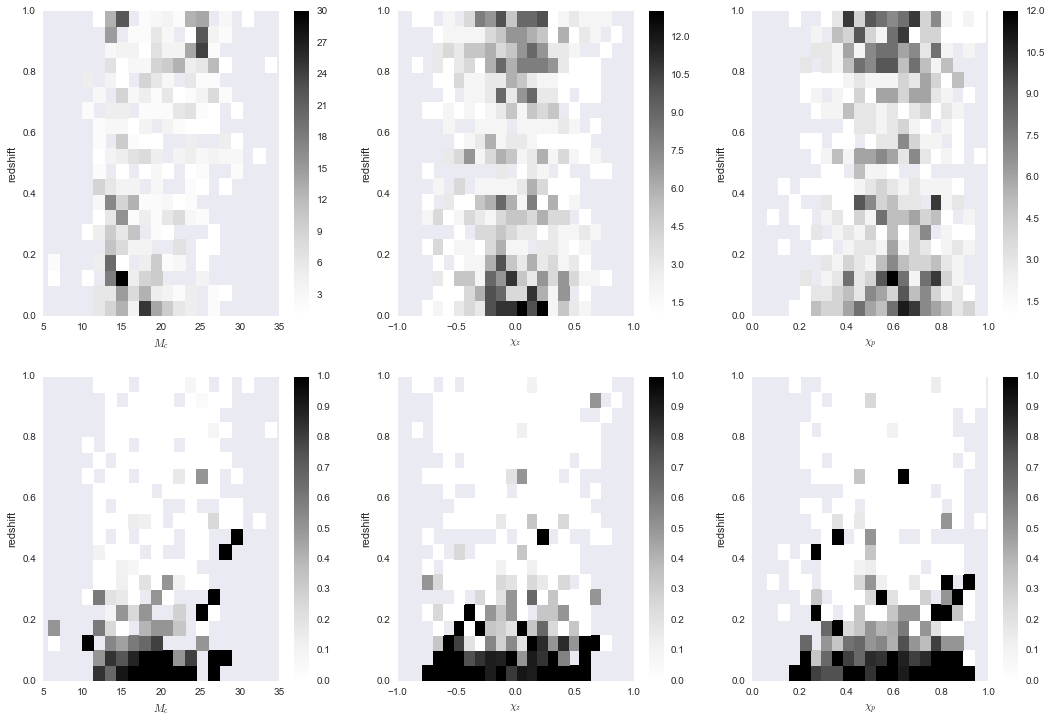

In [82]:
# Bin up the selection function (2D)
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
h_denom, x, y = np.histogram2d(zsamp['mc'], zsamp['z'], bins=(20, 20))
h_denom.dtype = float
h_denom = np.ma.masked_equal(h_denom, 0)
plt.pcolor(x, y, h_denom.T)
plt.colorbar()
plt.xlabel(r"$M_c$")
plt.ylabel("redshift")
# Plot those with SNR > 8
plt.subplot(2,3,4)
select = zsamp['snr'] > 8
h, x, y = np.histogram2d(zsamp[select]['mc'], zsamp[select]['z'], bins=(x, y))
plt.pcolor(x, y, (h/h_denom).T, vmin=0., vmax=1.)
plt.xlabel(r"$M_c$")
plt.ylabel("redshift")
plt.colorbar()

plt.subplot(2,3,2)
h_denom, x, y = np.histogram2d(zsamp['chi_z'], zsamp['z'], bins=(20, 20))
h_denom.dtype = float
h_denom = np.ma.masked_equal(h_denom, 0)
plt.pcolor(x, y, h_denom.T)
plt.colorbar()
plt.xlabel(r"$\chi_z$")
plt.ylabel("redshift")
# Plot those with SNR > 8
plt.subplot(2,3,5)
h, x, y = np.histogram2d(zsamp[select]['chi_z'], zsamp[select]['z'], bins=(x, y))
plt.pcolor(x, y, (h/h_denom).T, vmin=0., vmax=1.)
plt.xlabel(r"$\chi_z$")
plt.ylabel("redshift")
plt.colorbar()

plt.subplot(2,3,3)
h_denom, x, y = np.histogram2d(zsamp['chi_p'], zsamp['z'], bins=(20, 20))
h_denom.dtype = float
h_denom = np.ma.masked_equal(h_denom, 0)
plt.pcolor(x, y, h_denom.T)
plt.colorbar()
plt.xlabel(r"$\chi_p$")
plt.ylabel("redshift")
# Plot those with SNR > 8
plt.subplot(2,3,6)
h, x, y = np.histogram2d(zsamp[select]['chi_p'], zsamp[select]['z'], bins=(x, y))
plt.pcolor(x, y, (h/h_denom).T, vmin=0., vmax=1.)
plt.xlabel(r"$\chi_p$")
plt.ylabel("redshift")
plt.colorbar();

#plt.savefig('2D selection functions')

5.36037895867 Gpc3 1085.68114328 Mpc


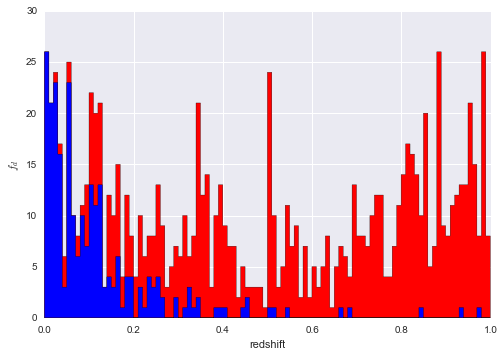

In [90]:
# Bin up the selection function

denom, b, _ = plt.hist(zsamp['z'], bins=100, color='r', histtype='stepfilled');
h, _, _ = plt.hist(zsamp[zsamp['snr']>8]['z'], bins=b, color='b', histtype='stepfilled')
plt.xlabel("redshift")
plt.ylabel(r"$f_d$")
plt.savefig("fofz_z.png")

z_vals = b[1:]
dz = b[1] - b[0]
z_vals += dz

f = h / denom.astype(float)

dVdz = cosmology.Planck15.differential_comoving_volume(z_vals)
v_c = 4 * np.pi * astropy.units.sr * np.sum(dVdz / (1+z_vals) * f) * dz
d_c = (v_c * 3 / 4 / np.pi)**(1.0/3)

print v_c.to("Gpc^3"), d_c

### Look at varying degrees of overlap ###

In [91]:
snr_cut = zsamp['snr'] > 8

precessing
4.90332129461 Gpc3 1053.90285451 Mpc
nonprecessing
4.40278864811 Gpc3 1016.74741343 Mpc


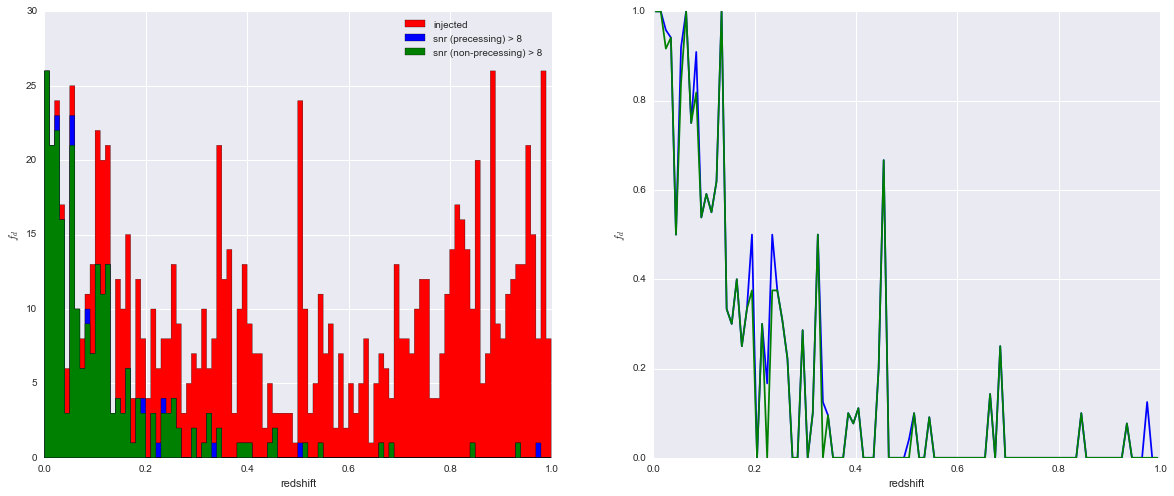

In [93]:
# Bin up the selection function
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

denom, b, _ = plt.hist(zsamp['z'], bins=100, color='r', histtype='stepfilled', label="injected")

snr_cut = zsamp['snr'] > 8
olap_cut = (zsamp['snr']*zsamp['overlap']) > 8
h, _, _ = plt.hist(zsamp[snr_cut]['z'], bins=b, histtype='stepfilled', \
                      color='b', label="snr (precessing) > 8")
f_precess = h / denom

h, _, _ = plt.hist(zsamp[olap_cut]['z'], bins=b, histtype='stepfilled', \
                      color='g', label="snr (non-precessing) > 8")
f_noprecess = h / denom

plt.xlabel("redshift")
plt.ylabel(r"$f_d$")
plt.savefig("fofz_z.png")

z_vals = np.copy(b[1:])
dz = b[1] - b[0]
z_vals -= dz/2

f = h / denom.astype(float)

dVdz = cosmology.Planck15.differential_comoving_volume(z_vals)
v_c = 4 * np.pi * astropy.units.sr * np.sum(dVdz / (1+z_vals) * f_precess) * dz
d_c = (v_c * 3 / 4 / np.pi)**(1.0/3)

print "precessing"
print v_c.to("Gpc^3"), d_c

dVdz = cosmology.Planck15.differential_comoving_volume(z_vals)
v_c = 4 * np.pi * astropy.units.sr * np.sum(dVdz / (1+z_vals) * f_noprecess) * dz
d_c = (v_c * 3 / 4 / np.pi)**(1.0/3)

print "nonprecessing"
print v_c.to("Gpc^3"), d_c


plt.legend();

plt.subplot(1,2,2)
plt.xlabel("redshift")
plt.ylabel(r"$f_d$")
plt.plot(z_vals, f_precess, 'b-', label="precessing")
plt.plot(z_vals, f_noprecess, 'g-', label="non-precessing")

### Make cut based on overlap difference

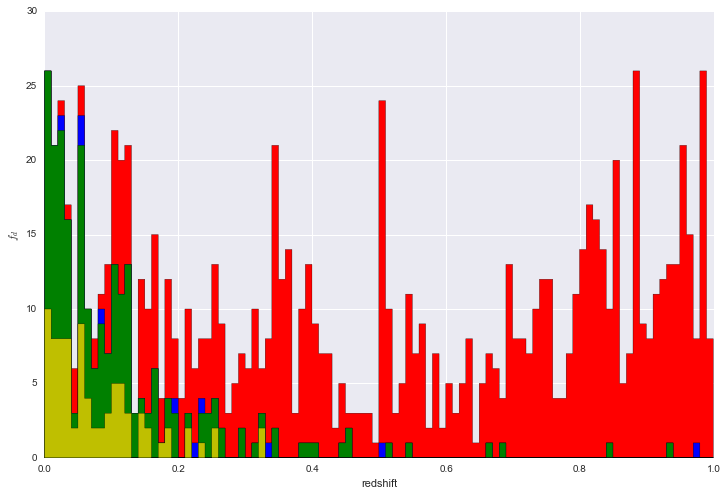

In [102]:
olap_threshold = 0.97 # Set this to whatever threshold you want

detectable_samples = zsamp[olap_cut]
olap_diff = detectable_samples['overlap'] < olap_threshold
distinguishable_samples = detectable_samples[olap_diff]

distinguishable_cut = ((zsamp['snr']*zsamp['overlap']) > 8) & (zsamp['overlap'] < olap_threshold)

# Plot this on the histogram as well
plt.figure(figsize=(12,8))
h, b, _ = plt.hist(zsamp['z'], bins=100, color='r', histtype='stepfilled', label="injected")
plt.hist(zsamp[snr_cut]['z'], bins=b, histtype='stepfilled', color='b', label="snr (precessing) > 8")
plt.hist(zsamp[olap_cut]['z'], bins=b, histtype='stepfilled', color='g', label="snr (non-precessing) > 8")
plt.hist(zsamp[distinguishable_cut]['z'], bins=b, histtype='stepfilled', color='y', label="distinguishable (overlap < 0.9)")
plt.xlabel("redshift")
plt.ylabel(r"$f_d$")

### Make cut based on cycles in band

In [103]:
def time_in_band(mc, f_low):
    return 2.18 * (1.21 / mc)**(5/3.) * (100./f_low)**(8./3)

def r_of_t(m1, m2, t):
    """
    Return separation distance as function of time to coalescence.
    """
    mt = (m1 + m2) * lal.MSUN_SI
    mu = (m1 * m2) / mt * lal.MSUN_SI**2
    return (t / (5/256. * lal.C_SI**5 / lal.G_SI**3 / mt**2 / mu))**0.25


# zsamp: [mc, z, snr, chi_z, chi_p, overlap w/ non-precessing analog, s1_vec, s2_vec, m1, m2]
def cycles_in_band(zsamp, flow):
    m1 = zsamp['m1']
    m2 = zsamp['m2']
    t_to_merg = time_in_band(zsamp['mc'], flow)
    r_of_t_over_m = r_of_t(m1, m2, t_to_merg) / (lal.G_SI/lal.C_SI**2 * lal.MSUN_SI * (m1+m2))

    # Mass
    M = m1+m2
    q=[]
    for i in xrange(len(zsamp)):
        if m1[i]>m2[i]: 
            q.append(m2[i]/m1[i])
        elif m1[i]<m2[i]: 
            q.append(m1[i]/m2[i])
    q = np.asarray(q)
    
    # Get spin magnitudes of the samples
    s1x,s1y,s1z = zsamp['s1x'],zsamp['s1y'],zsamp['s1z']
    s2x,s2y,s2z = zsamp['s2x'],zsamp['s2y'],zsamp['s2z']
    s1_mag = np.sqrt(s1x**2 + s1y**2 + s1z**2)
    s2_mag = np.sqrt(s2x**2 + s2y**2 + s2z**2)
    
    # The precession code expects |S|/M_total^2, |J|/M_total^2, r/M_total, ...
    s1_mt = s1_mag / M
    s2_mt = s2_mag / M
    
    # Get spin angles
    tilt1 = np.arccos(s1z/s1_mag)
    tilt2 = np.arccos(s2z/s2_mag)
    s1_p = s1_mag * np.sin(tilt1) # In-plane spins
    s2_p = s2_mag * np.sin(tilt2)
    dphi = np.arccos( (s1x * s2x + s1y * s2y) / s1_p / s2_p )
    
    periods=[]
    for i in xrange(len(zsamp)):
        # Use precession.from_the_angles, won't work for a vector for some reason so need to iterate
        xi, total_ang_mom, spin_mag = precession.from_the_angles(tilt1[i], tilt2, \
                            dphi[i], q[i], s1_mt[i], s2_mt[i], r_of_t_over_m[i])
    
    # Calculate precessional angular frequency at f_low
    omega_prec = precession.Omegaz(spin_mag, xi, total_ang_mom, q[i], s1_mt[i], s2_mt[i], \
                                       r_of_t_over_m[i]) * lal.C_SI**3 / lal.G_SI / (M[i]*lal.MSUN_SI)
    # Covert angular frequency to precessional period   
    period_prec = 2*math.pi / omega_prec
                
    return (t_to_merg / period_prec)


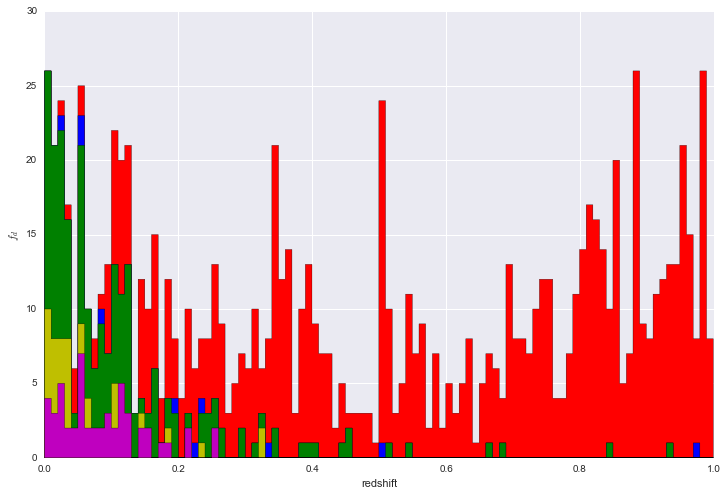

In [104]:
# Specify cutoff for number of cycles to determine precession
min_cycles = 1.0

cycles = cycles_in_band(zsamp, 20) # Setting flow to 20 Hz

measureable_cut = ((zsamp['snr']*zsamp['overlap']) > 8) & (zsamp['overlap'] < olap_threshold) & (cycles > min_cycles)

# Plot this on the histogram as well
plt.figure(figsize=(12,8))
h, b, _ = plt.hist(zsamp['z'], bins=100, color='r', histtype='stepfilled', label="injected")
plt.hist(zsamp[snr_cut]['z'], bins=b, histtype='stepfilled', color='b', label="snr (precessing) > 8")
plt.hist(zsamp[olap_cut]['z'], bins=b, histtype='stepfilled', color='g', label="snr (non-precessing) > 8")
plt.hist(zsamp[distinguishable_cut]['z'], bins=b, histtype='stepfilled', color='y', label="distinguishable (overlap < max_val)")
plt.hist(zsamp[measureable_cut]['z'], bins=b, histtype='stepfilled', color='m', label="measureable (cycles > min_val)")
plt.xlabel("redshift")
plt.ylabel(r"$f_d$")